# Georgia

The Georgia

In [19]:
import datetime as dt
import itertools as it
import numpy as np
import time
import pandas as pd
pd.set_option('display.max_columns', 50)

import requests
from bs4 import BeautifulSoup
import tabula

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [20]:
today = time.strftime("%Y-%m-%d")
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
month_dict_rev = {j:i for i,j in month_dict.items()}
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',
                   3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
alldates = pd.date_range(start='2006-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}
dates_tt = [i for i in DATERANGE if i[-2:]=='01']
dates_ll = [month_dict[i[5:7]] if i[5:]!='01-01' else i[:4] for i in dates_tt]

# Population Data

In [22]:
ga_url = 'http://www.dcor.state.ga.us/Research/Monthly_Profile_all_inmates'
ga_base = 'http://www.dcor.state.ga.us'

In [23]:
ga_urls = []
reqs = requests.get(ga_url)
soup = BeautifulSoup(reqs.text, 'html.parser')
for link in soup.find_all('a'):
#     print(link)
    x = link.get('href')
    try:
        if "Profile_all_inmates" in x:
            if '_2006_' in x or '_2007_' in x or '_2008_' in x or '_2009_' in x\
            or '_2010_' in x or '_2011_' in x or '_2012_' in x or '_2013_' in x\
            or '_2014_' in x or '_2015_' in x or '_2016_' in x or '_2017_' in x\
            or '_2018_' in x or '_2019_' in x or '_2020_' in x or '_2021_' in x:
                x = ga_base+x
                ga_urls.append(x)
    except:
        continue

ga_urls.append('http://www.dcor.state.ga.us/sites/all/files/pdf/Research/Monthly/Profile_all_inmates_2006_10.pdf')
ga_urls = sorted(ga_urls)

In [25]:
ga_example = ga_urls[-1]
date = "-".join(ga_example.split('_all_inmates_')[-1].split('.')[0].split('_'))+'-01'
print(date)
pp = 6
if date[:4]>='2015':
    pp = 5

dfs = tabula.read_pdf(ga_example, stream=True, pages=pp)
df_i = dfs[0].copy()
df_i.columns = df_i.iloc[0]
df_i = df_i[1:]


2021-08-01


In [5]:
ga_out_df = []
for ga_example in sorted(ga_urls):
    date = "-".join(ga_example.split('_all_inmates_')[-1].split('.')[0].split('_'))+'-01'
    print(date)
    pp = 6
    if date[:4]>='2015':
        pp = 5

    dfs = tabula.read_pdf(ga_example, stream=True, pages=pp)
    df_i = dfs[0].copy()
    df_i.columns = df_i.iloc[0]
    df_i = df_i[1:]
    if "Marital Status" in list(df_i.columns):
        pp -= 1
        dfs = tabula.read_pdf(ga_example, stream=True, pages=pp)
        df_i = dfs[0].copy()
        df_i.columns = df_i.iloc[0]
        df_i = df_i[1:]
    elif "Current Age" in list(df_i.columns):
        pp += 1
        dfs = tabula.read_pdf(ga_example, stream=True, pages=pp)
        df_i = dfs[0].copy()
        df_i.columns = df_i.iloc[0]
        df_i = df_i[1:]
#     if date[:4]>='2015':
#         dfs = tabula.read_pdf(ga_example, stream=True, pages=5)
#     else:
#         dfs = tabula.read_pdf(ga_example, stream=True, pages=6)
#     df_i = dfs[0].copy()
#     df_i.columns = df_i.iloc[0]
#     df_i = df_i[1:]

    df_i['Total'] = pd.Series(df_i['Total Col %'].str.split(' ').str[0]).values
    df_i['TotCol %'] = pd.Series(df_i['Total Col %'].str.split(' ').str[-1]).values
    df_i.columns = ['race', 'inmates_male_count', 'inmates_male_colpct', 'inmates_male_rowpct',
                            'inmates_female_count', 'inmates_female_colpct', 'inmates_female_rowpct',
                            'drop','inmates_total_count', 'inmates_total_pct']
    df_i = df_i[[i for i in df_i.columns if i != 'drop']].copy()
    df_i = df_i[[i for i in df_i.columns if 'pct' not in i]].copy()
    df_i = df_i.loc[df_i['race']!='Total Reported'].copy()
    df_i['race'] = [" ".join(i) for i in df_i['race'].str.split(' ').str[1:].str[:]]
    df_i.loc[df_i['inmates_male_count'].isna(),'inmates_male_count'] = '0'
    df_i.loc[df_i['inmates_female_count'].isna(),'inmates_female_count'] = '0'
    df_i.loc[df_i['inmates_total_count'].isna(),'inmates_total_count'] = '0'
    df_i['inmates_male_count'] = df_i['inmates_male_count'].str.replace(',','').astype(int)
    df_i['inmates_female_count'] = df_i['inmates_female_count'].str.replace(',','').astype(int)
    df_i['inmates_total_count'] = df_i['inmates_total_count'].str.replace(',','').astype(int)

    df_i['date'] = date
    df_i = df_i[['race', 'date', 'inmates_male_count', 'inmates_female_count', 'inmates_total_count']].copy()
    
    ga_out_df.append(df_i)

2006-01-01
2006-02-01
2006-03-01
2006-04-01
2006-05-01
2006-06-01
2006-07-01
2006-08-01
2006-09-01
2006-10-01
2006-11-01
2006-12-01
2007-01-01
2007-02-01
2007-03-01
2007-04-01
2007-05-01
2007-06-01
2007-07-01
2007-08-01
2007-09-01
2007-10-01
2007-11-01
2007-12-01
2008-01-01
2008-02-01
2008-03-01
2008-04-01
2008-05-01
2008-06-01
2008-07-01
2008-08-01
2008-09-01
2008-10-01
2008-11-01
2008-12-01
2009-01-01
2009-02-01
2009-03-01
2009-04-01
2009-06-01
2009-07-01
2009-08-01
2009-09-01
2009-10-01
2009-11-01
2009-12-01
2010-01-01
2010-02-01
2010-03-01
2010-04-01
2010-05-01
2010-06-01
2010-07-01
2010-08-01
2010-09-01
2010-10-01
2010-11-01
2010-12-01
2011-01-01
2011-02-01
2011-03-01
2011-04-01
2011-05-01
2011-06-01
2011-07-01
2011-08-01
2011-09-01
2011-10-01
2011-11-01
2011-12-01
2012-01-01
2012-02-01
2012-03-01
2012-04-01
2012-05-01
2012-06-01
2012-07-01
2012-08-01
2012-09-01
2012-10-01
2012-11-01
2012-12-01
2013-01-01
2013-02-01
2013-03-01
2013-04-01
2013-05-01
2013-06-01
2013-07-01
2013-08-01

In [6]:
ga_df = pd.concat(ga_out_df).reset_index().iloc[:,1:]
races = ['White', 'Black', 'Indian', 'Asian', 'Other', 'Unknown', 'Hispanic',
         'Racially Mixed', 'Native American', 'Native Hawaiian']
ga_df = ga_df.loc[ga_df['race'].isin(races)].copy().sort_values(['date',
                                                   'race']).reset_index().iloc[:,1:]

In [7]:
r = ga_df['race'].unique()[0]
ga_df_x = ga_df.loc[ga_df['race']==r].copy()
ga_df_x['incarcerated_%s'%r.lower()] = ga_df_x['inmates_total_count']
ga_df_x['incarcerated_%s_male'%r.lower()] = ga_df_x['inmates_male_count']
ga_df_x['incarcerated_%s_female'%r.lower()] = ga_df_x['inmates_female_count']
ga_df_x = ga_df_x[['date',
                   'incarcerated_%s'%r.lower(),
                   'incarcerated_%s_male'%r.lower(),
                   'incarcerated_%s_female'%r.lower()]].copy()

for r in ga_df['race'].unique()[1:]:
    ga_df_i = ga_df.loc[ga_df['race']==r].copy()
    ga_df_i['incarcerated_%s'%r.lower().replace(' ','')] = np.nan_to_num(
                                                            ga_df_i['inmates_total_count']).astype(int)
    ga_df_i['incarcerated_%s_male'%r.lower().replace(' ','')] = np.nan_to_num(
                                                            ga_df_i['inmates_male_count']).astype(int)
    ga_df_i['incarcerated_%s_female'%r.lower().replace(' ','')] = np.nan_to_num(
                                                            ga_df_i['inmates_female_count']).astype(int)
    ga_df_i = ga_df_i[['date',
                       'incarcerated_%s'%r.lower().replace(' ',''),
                       'incarcerated_%s_male'%r.lower().replace(' ',''),
                       'incarcerated_%s_female'%r.lower().replace(' ','')]].copy()
    ga_df_x = ga_df_x.merge(ga_df_i, how='left', on='date')

# for i in ga_df_x.columns[1:]:
#     ga_df_x[i] = np.nan_to_num(ga_df_x[i]).astype(int)

In [8]:
ga_df_x['incarcerated_total'] = ga_df_x[['incarcerated_asian', 'incarcerated_black',
                                         'incarcerated_indian', 'incarcerated_white',
                                         'incarcerated_hispanic', 'incarcerated_nativeamerican',
                                         'incarcerated_other', 'incarcerated_raciallymixed',
                                         'incarcerated_unknown', 'incarcerated_nativehawaiian']].sum(axis=1)

ga_df_x['incarcerated_total_male'] = ga_df_x[[i for i in ga_df_x.columns if "_male" in i]].sum(axis=1)
ga_df_x['incarcerated_total_female'] = ga_df_x[[i for i in ga_df_x.columns if "_female" in i]].sum(axis=1)

ga_df_x = ga_df_x[['date',
                   'incarcerated_total',
                   'incarcerated_asian',
                   'incarcerated_black',
                   'incarcerated_hispanic',
                   'incarcerated_nativeamerican',
                   'incarcerated_other',
                   'incarcerated_unknown',
                   'incarcerated_white',
                   'incarcerated_nativehawaiian',
                   'incarcerated_indian',
                   'incarcerated_raciallymixed',
                   'incarcerated_total_male',
                   'incarcerated_total_female',
                   'incarcerated_asian_male',
                   'incarcerated_black_male',
                   'incarcerated_hispanic_male',
                   'incarcerated_nativeamerican_male',
                   'incarcerated_other_male',
                   'incarcerated_unknown_male',
                   'incarcerated_white_male',
                   'incarcerated_nativehawaiian_male',
                   'incarcerated_indian_male',
                   'incarcerated_raciallymixed_male',
                   'incarcerated_asian_female',
                   'incarcerated_black_female',
                   'incarcerated_hispanic_female',
                   'incarcerated_nativeamerican_female',
                   'incarcerated_other_female',
                   'incarcerated_unknown_female',
                   'incarcerated_white_female',
                   'incarcerated_nativehawaiian_female',
                   'incarcerated_indian_female',
                   'incarcerated_raciallymixed_female']].copy()

In [9]:
# ga_df_x.to_csv('../data/incarceration/georgia_incarceration_race.csv',index=False)

In [4]:
ga_df_x = pd.read_csv('../data/incarceration/georgia_incarceration_race.csv')

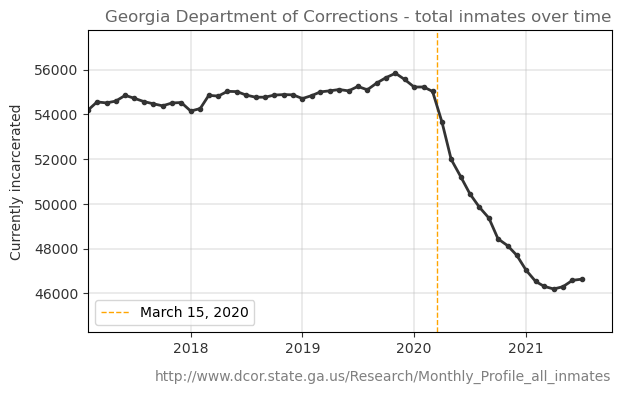

In [5]:
max_val = ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_total'].max()
min_val = ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_total'].min()
difvals = max_val-min_val
ylims = (min_val-difvals*0.2, max_val+difvals*0.2)
# ylims = (45000, 58000)
fig, ax = plt.subplots(1,1,figsize=(6.75,4),dpi=100)
ax.plot([date_dict[i] for i in ga_df_x['date']],
         ga_df_x['incarcerated_total'], lw=2, color='.2', marker='.')
ax.vlines(date_dict['2020-03-15'], ylims[0],ylims[1],
          color='orange', linestyle='--', lw=1, label='March 15, 2020')

ax.legend(loc=3)
ax.grid(lw=1.25, alpha=0.35, color='.75')
ax.tick_params(labelcolor='.2', color='.2')

ax.set_title('Georgia Department of Corrections - total inmates over time',x=1.0,ha='right',color='.4')
ax.text(1.0, -0.125, ga_url, transform=ax.transAxes, ha='right', va='top', color='.5')
ax.set_ylim(ylims[0],ylims[1])

ax.text(-0.15, 0.5, 'Currently incarcerated',color='.2',transform=ax.transAxes,rotation=90, va='center')
ax.set_xticks([date_dict[i] for i in
               ['2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-01-01']])
ax.set_xticklabels(['2017','2018','2019','2020','2021'])
ax.set_xlim(date_dict['2017-02-01'],date_dict[today]+30)

# plt.savefig('../figs/pngs/inmate_population_overtime_ga.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/inmate_population_overtime_ga.pdf',bbox_inches='tight')
plt.show()

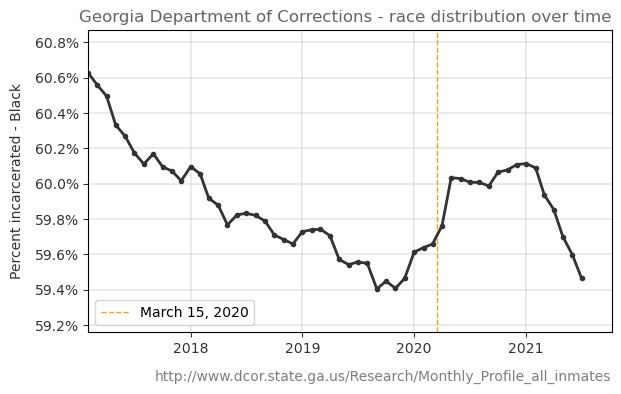

In [16]:
max_val = (ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_black']/\
           ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_total']).max()
min_val = (ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_black']/\
           ga_df_x.loc[ga_df_x['date']>'2017-01-01']['incarcerated_total']).min()
difvals = max_val-min_val
ylims = (min_val-difvals*0.2, max_val+difvals*0.2)

fig, ax = plt.subplots(1,1,figsize=(6.75,4),dpi=100)
ax.plot([date_dict[i] for i in ga_df_x['date']],
         (ga_df_x['incarcerated_black']/ga_df_x['incarcerated_total']).rolling(window=1).mean(),
        lw=2, color='.2', marker='.')
ax.vlines(date_dict['2020-03-15'], ylims[0],ylims[1],
          color='orange', linestyle='--', lw=1, label='March 15, 2020')

ax.legend(loc=3)
ax.grid(lw=1.25, alpha=0.35, color='.75')
ax.tick_params(labelcolor='.2', color='.2')

ax.set_title('Georgia Department of Corrections - race distribution over time',x=1.0,ha='right',color='.4')
ax.text(1.0, -0.125, ga_url, transform=ax.transAxes, ha='right', va='top', color='.5')
ax.set_ylim(ylims[0],ylims[1])

ax.text(-0.15, 0.5, 'Percent incarcerated - Black',color='.2',transform=ax.transAxes,rotation=90, va='center')
ax.set_xticks([date_dict[i] for i in
               ['2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-01-01']])
ax.set_xticklabels(['2017','2018','2019','2020','2021'])
ax.set_xlim(date_dict['2017-02-01'],date_dict[today]+30)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))

# plt.savefig('../figs/pngs/inmate_population_overtime_ga_pct_black.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/inmate_population_overtime_ga_pct_black.pdf',bbox_inches='tight')
plt.show()